In [10]:
#common imports
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import listdir, remove

#keras imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, RandomFlip, RandomRotation, Rescaling, add, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dropout
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, plot_model
from tensorflow.data import AUTOTUNE
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import ModelCheckpoint, BackupAndRestore

import ipynbname

#Hyperparameters
OPTIMIZER = Adam
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy')]
EPOCHS = 25
BATCH_SIZE = 32
VERBOSE = 2
REGULARIZER=None
NUMBER_OF_CLASSES = 2
INPUT_SHAPE = (256,256,1)

#variables
drive_dir_colab = '/content/drive/MyDrive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'
drive_dir_mac = '/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'

DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = drive_dir_mac
TOP_DIRECTORY_CLASSIFIFICATIONS = join(DATASET_DIRECTORY ,'categorised_images')

#notebook attributes
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#to run locally on mac see : https://github.com/tensorflow/tensorflow/issues/33285
#'/Users/chris/PycharmProjects/Tensorflow/.venv/lib/python3.11/site-packages/tensorflow/python/keras/utils/data_utils.py'

In [8]:
def check_for_corrupted_images(a_folder_path):
    #checks for any files that are not actually images or images that keras can process
    from pathlib import Path
    import imghdr

    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(a_folder_path).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [12]:
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [13]:
#Check for any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        check_for_corrupted_images(folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_no_fracture
/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_no_fracture/image1_109_png.rf.16f53a0df738944f669a1562ec5243ef.jpg is not an image
/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent Universit

In [14]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [15]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 36291 files belonging to 2 classes.
Found 1690 files belonging to 2 classes.
Found 3480 files belonging to 2 classes.


2024-03-16 22:05:47.963407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


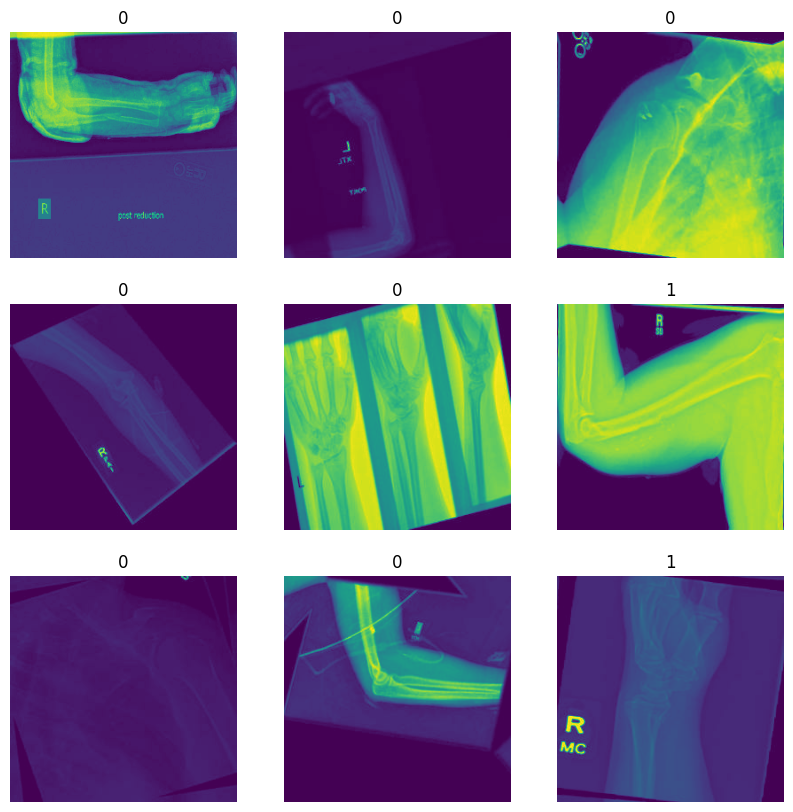

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [17]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

In [18]:
def create_model(input_shape, num_classes):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
   
    #Flatten the output so that it can be processed as a Vector by the subsequnet Dense layer
    model.add(Flatten())

    #add a fully connected layer with  64 neurons and a relu activation function ouput shape = 64
    model.add(Dense(64, kernel_regularizer=REGULARIZER, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [19]:
model = create_model(input_shape=INPUT_SHAPE, num_classes=NUMBER_OF_CLASSES)
plot_model(model, show_shapes=True)
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    31,490,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,564,673 (120.41 MB)

 Trainable params: 31,564,673 (120.41 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer=OPTIMIZER(),loss=LOSS_FUNCTION(),metrics=METRICS)

In [21]:
callbacks = [
             ModelCheckpoint(
                filepath= join(DATASET_DIRECTORY, 'checkpoints', nb_fname + '_checkpoint_at_{epoch}.keras'),
                monitor='val_accuracy',
                mode='max',
                save_best_only=True),
             BackupAndRestore(
                backup_dir= join(DATASET_DIRECTORY, 'backups', nb_fname + '_backup_at_{epoch}.keras'),
                save_freq="epoch",
                delete_checkpoint=True)
            ]

model_history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data=valid_ds
                        )

clear_session

Epoch 1/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1461s 1s/step - accuracy: 0.5149 - loss: 0.7333 - val_accuracy: 0.4793 - val_loss: 0.6966
Epoch 2/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1450s 1s/step - accuracy: 0.5635 - loss: 0.6760 - val_accuracy: 0.4825 - val_loss: 0.7279
Epoch 3/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1451s 1s/step - accuracy: 0.6031 - loss: 0.6436 - val_accuracy: 0.4934 - val_loss: 0.8168
Epoch 4/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1449s 1s/step - accuracy: 0.6837 - loss: 0.5646 - val_accuracy: 0.5095 - val_loss: 1.0079
Epoch 5/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1450s 1s/step - accuracy: 0.7841 - loss: 0.4335 - val_accuracy: 0.5124 - val_loss: 1.5273
Epoch 6/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1449s 1s/step - accuracy: 0.8591 - loss: 0.3082 - val_accuracy: 0.5075 - val_loss: 1.9388
Epoch 7/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1450s 1s/step - accuracy: 0.9099 - loss: 0.2163 - val_accuracy: 0.5095 - val_loss: 2.1757
Epoch 8/25
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1428s 1s/step - accuracy: 0.9386 -

<function keras.src.backend.common.global_state.clear_session()>

In [22]:
 evaluation = model.evaluate(test_ds)

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.5151 - loss: 3.6764


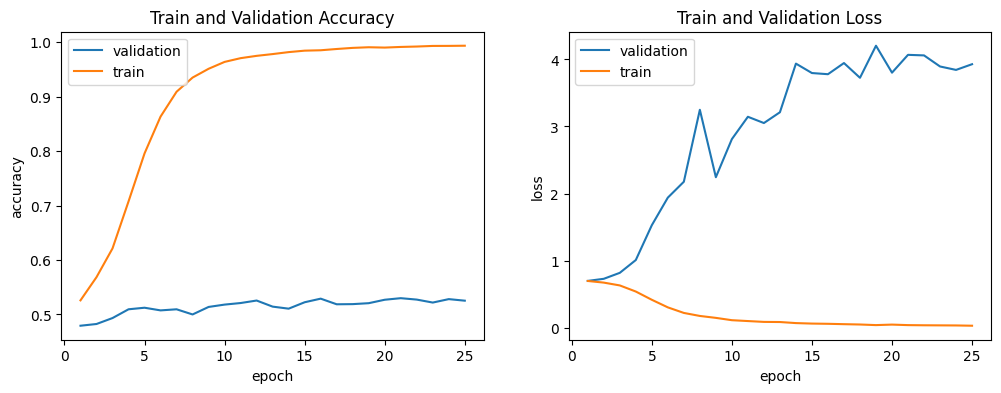

In [23]:
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, EPOCHS+1), valid_accuracy) 
accuracy.plot(range(1, EPOCHS+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, EPOCHS+1), valid_loss)
loss.plot(range(1, EPOCHS+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()